# Darija Text Preprocessing 

This notebook implements a comprehensive text preprocessing pipeline for Moroccan Arabic (Darija) text data. The pipeline includes:
- Text cleaning and normalization (Tachkeel, etc)
- Emoji handling
- Stop words removal
- Stemming
- Special character handling (#, @, $, etc.)
- Transliteration normalization(from Arabizi to Arabic)
- and more.

## Data Loading and Environment Setup
Setting up the working directory and checking available datasets

In [1]:
import os
os.chdir('/kaggle/input/ma-datasets') 
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)

Current working directory: /kaggle/input/ma-datasets
Directory contents: ['suf_pref_darija.json', 'stop_words_accum.json', 'set2.csv', 'set7.csv', 'set5.csv', 'darija_latin_ref.json', 'set4.csv', 'scaped_comments.csv', 'set3.csv', 'cleaned_clustered_data.csv', 'set1.csv']


## Required Dependencies
Installing necessary Python packages for Arabic text processing:
- PyArabic: For Arabic text processing
- Tashaphyne: For Arabic light stemming/lemmatization
- pydoda: For Darija-vacabulary processing
- Arabic-Stopwords: For Arabic stop words


In [2]:
!pip install PyArabic Tashaphyne pydoda Arabic-Stopwords seaborn emoji 
!pip install modin[ray]
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found 

In [3]:
os.environ["MODIN_ENGINE"] = "ray"
import modin.pandas as pd
import ray
ray.init()

2024-12-20 04:51:18,861	INFO worker.py:1753 -- Started a local Ray instance.


Python version:,3.10.14
Ray version:,2.24.0


## Import nessecery libraries


In [4]:
import modin.pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
from tashaphyne.stemming import ArabicLightStemmer
import json
from pyarabic.araby import strip_diacritics
import emoji 


## Text Preprocessing Functions
Implementing various text cleaning and normalization functions:
- Character normalization
- Emoji processing
- URL and mention removal
- Dialectal variation handling
- and more.

In [5]:
darija_alphabet = {
    "gh": "غ",
    "sh": "ش",
    "ch": "ش",
    "ss": "س",
    "kh": "خ",
    "ç": "س",
    "ou": "و",    
    "ei": "ي",    
    "ay": "ي",    
    "ae": "ي",   
    "5": "خ",     
    "2": "ا",    
    "b": "ب",
    "t": "ت",
    "j": "ج",
    "7": "ح",
    "d": "د",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "9": "ق",
    "3": "ع",
    "4": "غ",
    "f": "ف",
    "q": "ك",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي",
    "g": "ڭ",
    'i': 'ي',
    'ee': 'ي',
    'aa': 'ا',
    'oo': 'و',
    'o': 'و',
    "x": "ش",
}
word_in = [
    "ء", "أ", "إ", "آ", "ؤ", "ئ", "ة", "ى","-", "/", ".", "،", '"', "'", "\\", "?", "؟", "!", "،", "؛",":","#", "@", "&", "=", "¥", "$", "%", "*", "+", "<", ">", "|", "~", "^", 
    "\n", "\t", "\r", " و","ذ", "ظ", "ض", "ص","(", ")", "[", "]", "{", "}", "《", "》", "«", "»"
]

replaced_by = [
    "ا", "ا", "ا", "ا", "ا", "ا", "ه", "ي"," ", "", "", "", "", "", "", " ? ", " ؟ ", " ! ", "", "", "",
    "", "", "", "", "", "", "", "", "", "", "", "", "", ""," ", " ", " ", "",
    "د", "د", "د", "س","", "", "", "", "", "", "", "", "", ""
]

arabic_alphabet = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

In [6]:
from pyarabic.araby import strip_diacritics
#remove tashkeel
def removing_tashkeel(word): # useed
          return strip_diacritics(word)

In [7]:
from pyarabic.araby import strip_tatweel

#remove tatweel l2imdad
def removing_tatweel(word): # useed
          return strip_tatweel(word)

In [8]:
from pyarabic.araby import normalize_ligature

#remove ligature hamza , alef 
def removing_ligature(word): # not used 
          return normalize_ligature(word)

In [9]:
# remove underscore
def replace_underscore(word): # useed
          return word.replace("_", " ")

In [10]:
import pyarabic.araby as araby

# remove hamza ambiguity
def remove_ambiguity_hamza(word): # useed
          return araby.normalize_hamza(word)

In [11]:
# romove "AL"
def remove_AL(word): # useed
          return re.sub(r'^ال', '', word)

In [12]:
def word_remover(word):
    if len(word) == 1 or len(word) == 0 or len(word) >= 13:
        return ""
    else:
        try:
            for a7rf in arabic_alphabet:
                if a7rf == 'د' or a7rf == 'ه':
                    word = re.sub(fr'{a7rf}{{3,}}', a7rf * 2, word).strip()
                else:
                    word = re.sub(fr'{a7rf}+', a7rf, word).strip()
            for i in range(len(word)):
                if word[i] in word_in:
                    index = word_in.index(word[i])
                    word = word[:i] + replaced_by[index] + word[i + 1:]
            return word
        except IndexError as e:
            pass
            return word  #


In [13]:
# remove emails  
def remove_url(text): # useed
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',
                  '', text, flags=re.MULTILINE)
    return text      
 

In [14]:
 # remove emails     
def remove_emails(text): # useed
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text, flags=re.MULTILINE)
    return text  

In [15]:
def special_tags_and_ponctuations(text):  # Function to clean special tags
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'&quot;', '', text)  
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)

    return text

In [16]:
def remove_html_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    return text

In [17]:
# hundle emojis
def extend_spletting(items):  # helper function to split items
    spletting = []
    for item in items:
        spletting.extend(item.split())
    return spletting

In [18]:
def emoji_hundler(word):  # helper function to handle emojis
    word = emoji.demojize(word, language='ar')
    word = replace_underscore(word)[1:-1]
    return word

In [19]:
def is_an_emoji(word):
    emoji_pattern = re.compile("["  
                               u"\U0001F680-\U0001F6FF"  # transport and map unicods
                               u"\U0001F1E0-\U0001F1FF"  # flags unicods
                               "]+", flags=re.UNICODE)

    if emoji.is_emoji(word):
        word = emoji_pattern.sub(r'', word)
        return extend_spletting([emoji_hundler(word)])

    elif emoji.purely_emoji(word):
        data_of_emojis = emoji.distinct_emoji_list(word)
        data = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        return extend_spletting(data)

    else:
        text_only = re.sub(r'[^\w\s?!]', '', word)
        data_of_emojis = emoji.distinct_emoji_list(word)
        emojis = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        
        return [text_only] + extend_spletting(emojis)


In [20]:
# tramslating darija(latin) to daruja(arabic)
def translate_darija_to_arabic(word): # useed
    # print("test")
    word = word.lower()
    if  bool(re.compile(r"[a-z0-9']+").search(word)):
        arabic_word = ""
        i = 0
        while i < len(word):
            # print('sadd')
            if i + 1 < len(word) and word[i:i+2] in darija_alphabet: # Check for 2 lettrs
                arabic_word += darija_alphabet[word[i:i+2]]
                i += 2
            elif word[i] in darija_alphabet:
                arabic_word += darija_alphabet[word[i]]
                i += 1
            else:
                i += 1
        return arabic_word
    return word
      

In [21]:
# remove  number arabic and latin
def number_remov(listy): # useed
    number_pattern = re.compile(r'^[0-9\u0660-\u0669]+$')
    cleaned_list = [item for item in listy if not number_pattern.fullmatch(item)] 
    return cleaned_list   

In [22]:
#stemming arabic words     
def stemming_darija(word):
    # file = "./Data_prep/suf_pref_darija.json" # local run
    file = "suf_pref_darija.json" 

    with open(file, 'r', encoding='utf-8') as json_file:
        suf_pref = json.load(json_file)

    ArListem = ArabicLightStemmer()
    ArListem.set_prefix_list(suf_pref['darija_prefixes'])
    ArListem.set_suffix_list(suf_pref['darija_suffixes'])
    ArListem.light_stem(word)  
    return ArListem.get_stem() 

In [23]:
# "03:44"
def remove_yt_timers(text):
    pattern = r'\b\d{1,2}:\d{2,3}(:\d{2,3})?\b'
    text = re.sub(pattern, '', text)
    return text.strip()

In [24]:

def preproc_arab_sentence(word): # main function for  arab processing tokens
    word = removing_tashkeel(word)
    word = removing_tatweel(word)
    word = remove_AL(word)
    # word = remove_ambiguity_hamza(word)
    word = word_remover(word)
    return word


In [25]:
from pyarabic.araby import tokenize
def tokenize_arab_text(text):
            #print(text)
            # with open('./Data_prep/stop_words_accum.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./stop_words_accum.json', 'r', encoding='utf-8') as file:

                stop_words = json.load(file)

            # with open('./Data_prep/darija_latin_ref.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./darija_latin_ref.json', 'r', encoding='utf-8') as file:
                
                darija_latin_ref = json.load(file)
          
            #print(text)
            text = remove_url(text)
            text = remove_emails(text)
            text = replace_underscore(text)
            text = remove_html_tags(text)
            text = remove_yt_timers(text)
            text = special_tags_and_ponctuations(text)
            #tokenization
            #print(text)
            words = tokenize(text)
            # print(words)
            words = [ translate_darija_to_arabic(word) for word in words if word not in darija_latin_ref]
            #print(words)
            words = [is_an_emoji(word) for word in words] 
            words = [item for sublist in words for item in sublist if item]
            words = list(set(words))
            #print(words)        
            words = [word for word in words if word not in stop_words]
            #print(words)

            words = [preproc_arab_sentence(word) for word in words]

            # print(words)        
            words = [stemming_darija(word) for word in words if word]
            words = number_remov(words)


            # print(words)
            words = ' '.join(words) 
            return words

## Data Analysis and Visualization
Exploring the characteristics of the text data in different sets through visualizations

# Set 1

In [26]:
data = pd.read_csv("./set1.csv")
data.head()

,Unnamed: 0,comment,off
0,6139,تبهديل تسؤلو البنات في الشارع,1
1,3447,انا مستعد بي مسعدة بسيطة في وجه اللة ربي يادير...,0
2,6844,لاحول ولاقوة الا بالله العلي العظيم,0
3,2512,حتى هاد العائلة لي جالس وسط منهوم خص يدلمهوم ا...,1
4,2000,لا حول ولا قوة الا بالله اش هذا المستوى اصلا ر...,1


In [27]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1605 non-null   int64 
 1   comment     1605 non-null   object
 2   off         1605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 37.7+ KB


In [28]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.rename(columns={'off': 'target'})
data = data.rename(columns={'comment': 'text'})
data['target'] = data['target'].replace({1: 0, 0: 1})
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1605 non-null   object
 1   target  1605 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.2+ KB


In [29]:
data.head()

,text,target
0,تبهديل تسؤلو البنات في الشارع,0
1,انا مستعد بي مسعدة بسيطة في وجه اللة ربي يادير...,1
2,لاحول ولاقوة الا بالله العلي العظيم,1
3,حتى هاد العائلة لي جالس وسط منهوم خص يدلمهوم ا...,0
4,لا حول ولا قوة الا بالله اش هذا المستوى اصلا ر...,0


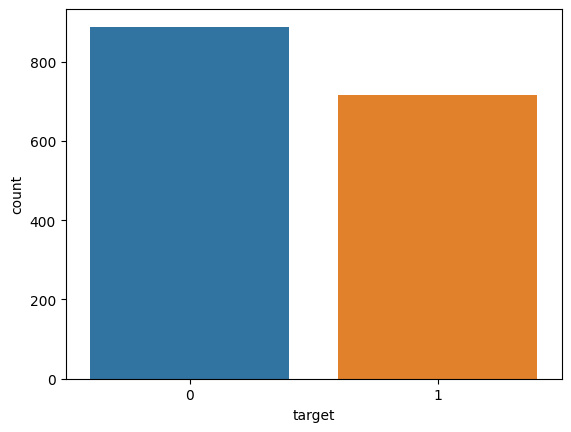

In [30]:
sns.countplot(data  , x='target' )
plt.show()

In [31]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 1584 entries, 0 to 1604
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1584 non-null   object
 1   target  1584 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.1+ KB


In [32]:
data['target'].value_counts()

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


target
0    876
1    708
Name: count, dtype: int64

In [33]:
data.to_csv("/kaggle/working/dataset1.csv" , index=False)

# Set 2

In [34]:
data = pd.read_csv("./set2.csv")
data.head()

,Unnamed: 0,comment,off
0,2908,فنانين الكبت والفساد .عقلية جنسية لا غير. العف...,1
1,1055,الدعارة هربت منها في المحمدية و سكنت في بوزنيق...,1
2,181,كون غير خريتي و مدرتيش هادشي,1
3,4313,لا حول ولا قوة الا بالله العلي العظيم لا حول و...,0
4,228,الله يرحم الوالدين عندي مشكل كبيييير و محتاجة ...,0


In [35]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6419 non-null   int64 
 1   comment     6419 non-null   object
 2   off         6419 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 150.6+ KB


In [36]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.rename(columns={'off': 'target'})
data = data.rename(columns={'comment': 'text'})
data['target'] = data['target'].replace({1: 0, 0: 1})
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6419 non-null   object
 1   target  6419 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 100.4+ KB


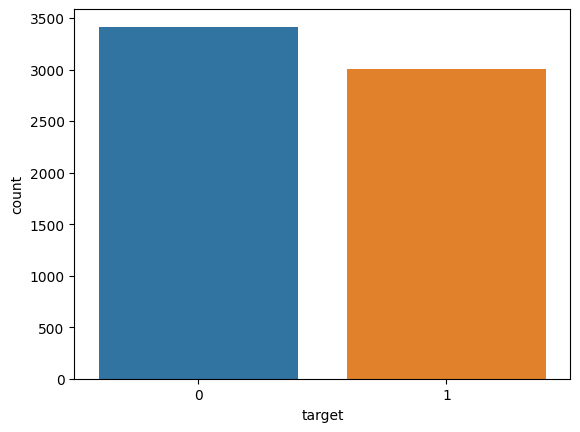

In [37]:
sns.countplot(data  , x='target' )
plt.show()

In [38]:
data.head()

,text,target
0,فنانين الكبت والفساد .عقلية جنسية لا غير. العف...,0
1,الدعارة هربت منها في المحمدية و سكنت في بوزنيق...,0
2,كون غير خريتي و مدرتيش هادشي,0
3,لا حول ولا قوة الا بالله العلي العظيم لا حول و...,1
4,الله يرحم الوالدين عندي مشكل كبيييير و محتاجة ...,1


In [39]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 6094 entries, 0 to 6418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6094 non-null   object
 1   target  6094 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


In [40]:
data['target'].value_counts()

target
0    3210
1    2884
Name: count, dtype: int64

In [41]:
data.to_csv("/kaggle/working/dataset2.csv" , index=False)

# Set 3

In [42]:
data = pd.read_csv('./set3.csv')
data.head()

,tweets,type,class
0,ماهي آرائكم متتبعي الكرام,neutral,standard
1,عبقرية المدرب وروعة اللاعبين,positive,standard
2,أمة عربية واحدة خالدة,positive,standard
3,عاد إليكم من جديد وأخيرا درت جيم لهاد الصفحة,neutral,dialectal
4,الله يخلف عليك سيدي محمد,positive,dialectal


In [43]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 18086 entries, 0 to 18085
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  18084 non-null  object
 1   type    18086 non-null  object
 2   class   18086 non-null  object
dtypes: object(3)
memory usage: 424.0+ KB


In [44]:
data = data[data['class'] == 'dialectal' ]
data.head()

,tweets,type,class
3,عاد إليكم من جديد وأخيرا درت جيم لهاد الصفحة,neutral,dialectal
4,الله يخلف عليك سيدي محمد,positive,dialectal
6,هجومك يا أخي على حسن طارق تبرهيش و قلة عقل ودل...,negative,dialectal
7,أمين عام حزب سياسي كينشر تدوينة وكيدير ليها جيم,neutral,dialectal
8,أجي بعدا فين غبرات واحد الحمى القلاعية شفت ما ...,neutral,dialectal


In [45]:
data.drop(columns=['class'], inplace=True)
data = data.rename(columns={'type': 'target'})
data = data.rename(columns={'tweets': 'text'})

In [46]:
data['target'].value_counts()

target
positive    2989
neutral     1309
negative     982
mixed        183
Name: count, dtype: int64

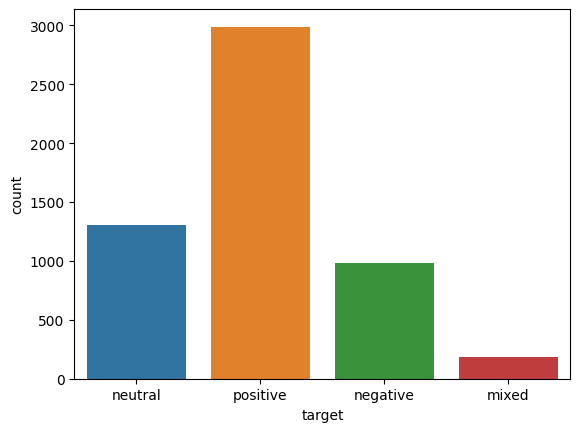

In [47]:
sns.countplot(x='target', data=data)
plt.show()

In [48]:
data=  data[ data['target'] != 'mixed'  ]
data=  data[ data['target'] != 'neutral'  ]

In [49]:
data['target'] = data['target'].replace({'positive': 1, 'negative': 0}).astype(int)

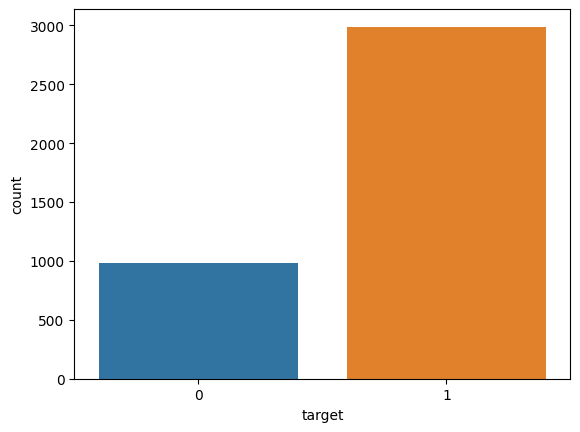

In [50]:
sns.countplot(x='target', data=data)
plt.show()

In [51]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 2671 entries, 4 to 13597
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2670 non-null   object
 1   target  2671 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [52]:
data['target'].value_counts()

target
1    1992
0     679
Name: count, dtype: int64

In [53]:
data.head()

,text,target
4,الله يخلف عليك سيدي محمد,1
6,هجومك يا أخي على حسن طارق تبرهيش و قلة عقل ودل...,0
15,شكرا يوسف سفري بوعميرة وبنحليب ديما راجا,1
28,الله يخلي لنيا العونيات,1
31,حدراف لاعب كبير وغادي يبقى كبير وبلاصتو كاينة ...,1


In [54]:
data.to_csv("/kaggle/working/dataset3.csv", index=False)

# Set 4

In [55]:
data = pd.read_csv('./set4.csv')
data.head()

,text,label
0,eh mais enfaite ‘zebi’ ça veut dire bise’ en v...,1
1,je vais me réveiller à 6h au lieu de 7h histoi...,1
2,ma matrixe la video il est trop chou zebi,1
3,mmh tu manquer l’odeur de ta culotte nahchtoul...,1
4,tantôt nari zebi zmagri le7ia dial bljika,1


In [56]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 20402 entries, 0 to 20401
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20402 non-null  object
 1   label   20402 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 318.9+ KB


In [57]:
data = data.rename(columns={'label': 'target'})

In [58]:
data['target'].value_counts()

target
0    12685
1     7717
Name: count, dtype: int64

In [59]:
data.dropna(inplace=True)

In [60]:
import re
def filter_and_analyze_text(text):
    if not isinstance(text, str):
        return None
    if re.search(r'[a-zA-Z]', text):
        return None       
    return text 
data["text"] = data["text"].apply(filter_and_analyze_text)

In [61]:
data= data.dropna()

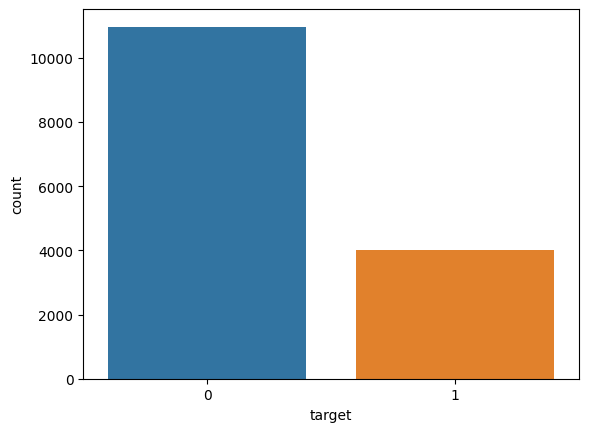

In [62]:
sns.countplot(x='target', data=data)
plt.show()

In [63]:
data['target'] = data['target'].replace({ 0: 1 , 1 : 0  })

In [64]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 11490 entries, 7 to 20401
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11490 non-null  object
 1   target  11490 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 269.3+ KB


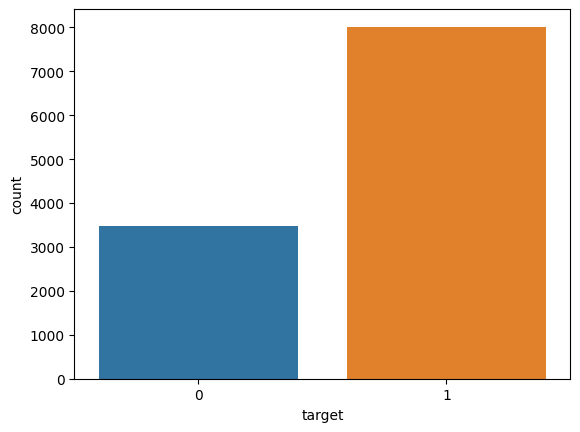

In [65]:
sns.countplot(x='target', data=data)
plt.show()

In [66]:
data['target'].value_counts()

target
1    8015
0    3475
Name: count, dtype: int64

In [67]:
data.head(30)

,text,target
7,ايش معولين احنا لزم مدير هدا المستشفي يتعاقب ه...,1
8,*الخامس* *رمز تعبيري معدل واحد* حتا انا عندي ت...,1
9,*السهم للاسفل* 1 بل و في نفس الوقت تمت الاشاده...,1
10,*السهم للاسفل* 1و الاستقرار في افريقيا و الشرق...,1
11,*العلم للجزاءر* رءيس الجزاءر نحن اول بلد افريق...,1
12,*العلم للمغرب* *العلم لمصر* يسعي فريق المصري ا...,1
13,*العلم للمغرب* *داءره حمراء* ربح الرياضي مبارا...,1
14,*العلم للمغرب* *داءره حمراء* قال فوزي مدرب الو...,1
15,*العلم للمغرب* *داءره حمراء* نجحت اداره فريق ا...,1
16,*العلم للمغرب* *داءره حمراء* يخوض فريق الرياضي...,1


In [68]:
data.to_csv("/kaggle/working/dataset4.csv", index=False)

# Set 5

In [69]:
data = pd.read_csv('./set5.csv')
data.head()

,index,comment_message,sentiment,comment_published
0,1,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,N,2016-10-01 00:07:44
1,2,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,P,2016-10-01 00:47:37
2,3,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,N,2016-10-01 00:48:02
3,4,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,N,2016-10-01 00:49:10
4,5,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,N,2016-10-01 00:59:47


In [70]:
data.drop(columns=["comment_published" , "index"] , inplace=True)
data['sentiment'] = data['sentiment'].replace({ "N": 0 , "P" : 1  })
data = data.rename(columns={'comment_message': 'text' , 'sentiment':'target'})

In [71]:
data.head()

,text,target
0,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,0
1,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,1
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,0
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,0
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,0


In [72]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10254 non-null  object
 1   target  10254 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.3+ KB


In [73]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10254 non-null  object
 1   target  10254 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.3+ KB


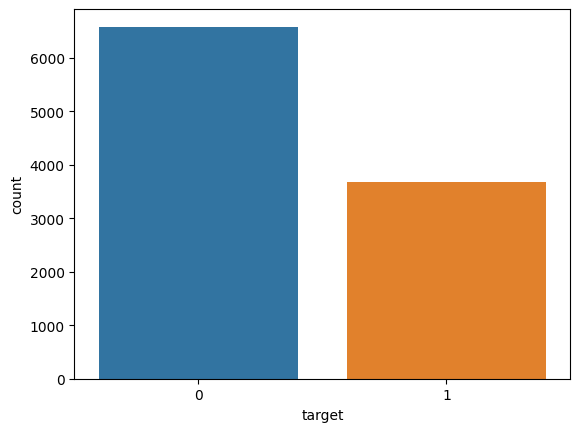

In [74]:
sns.countplot(x='target', data=data)
plt.show()

In [75]:
data['target'].value_counts()

target
0    6581
1    3673
Name: count, dtype: int64

In [76]:
data.to_csv("/kaggle/working/dataset5.csv", index=False)

# set 7

In [77]:
data = pd.read_csv('./set7.csv')
data.head()

,comment,label
0,العتماني عندو اللباقة و الجدال بالغة سد فمك,0
1,إن كتب لنا الموت بهذا الفيروس فذاك يبقى قضاء و...,0
2,خوتي الله ينجيكم من هاد الفيروس الخبيث يا رب ا...,0
3,الحمد لله على أن ڤيروس كورونا لا يعيش في ما فو...,0
4,و بخصوص الكمامات فهو على صواب الكمامة تحمي فقط...,0


In [78]:
data['label'] = data['label'].replace({ 1: 0 , 0 : 1  })
data = data.rename(columns={'comment': 'text' , 'label':'target'})

In [79]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4337 non-null   object
 1   target  4337 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.9+ KB


In [80]:
data = data.drop_duplicates(['text'])
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4337 non-null   object
 1   target  4337 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.9+ KB


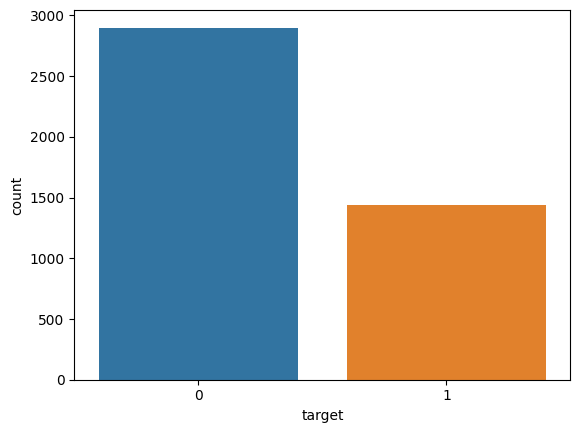

In [81]:
sns.countplot(x='target', data=data)
plt.show()

In [82]:
data['target'].value_counts()

target
0    2899
1    1438
Name: count, dtype: int64

In [83]:
data.to_csv("/kaggle/working/dataset7.csv", index=False)

# Set 6 (the unlabled one)

In [84]:
data = pd.read_csv('./cleaned_clustered_data.csv')
data.head()

,text_cleaned,cluster,target
0,من لديه اخر معلومات عن عبير,1,1
1,هه تراث مغربي حقيقي اصلي هه,1,1
2,ابوك يبقى ابوك .. حتى ولم لم يقدم اليك شيا,1,1
3,مهما كان ابيك فا يبقي ابيك مهما فعلت له فلا تف...,1,1
4,شيا لصدمني انا هو انكم كتقترحوا عليه اساله بصف...,1,1


In [85]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  488 non-null    object
 1   cluster       488 non-null    int64 
 2   target        488 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.6+ KB


In [86]:
data['target'].value_counts()

target
1    258
0    230
Name: count, dtype: int64

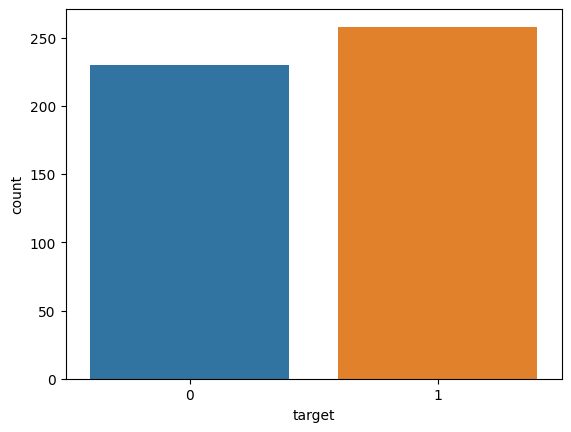

In [87]:
sns.countplot(x='target', data=data)
plt.show()

In [88]:
data['text'] = data['text_cleaned']
data.drop(columns=['cluster' , 'text_cleaned'] , inplace=True)


In [89]:
data.head()

,target,text
0,1,من لديه اخر معلومات عن عبير
1,1,هه تراث مغربي حقيقي اصلي هه
2,1,ابوك يبقى ابوك .. حتى ولم لم يقدم اليك شيا
3,1,مهما كان ابيك فا يبقي ابيك مهما فعلت له فلا تف...
4,1,شيا لصدمني انا هو انكم كتقترحوا عليه اساله بصف...


In [90]:
data.to_csv("/kaggle/working/dataset6.csv", index=False) 

## Merging the Datasets and Applying the Preprocessing Pipeline


In [91]:
df1  = pd.read_csv('/kaggle/working/dataset1.csv')
df2  = pd.read_csv('/kaggle/working/dataset2.csv')
df3  = pd.read_csv('/kaggle/working/dataset3.csv')
df4  = pd.read_csv('/kaggle/working/dataset4.csv')
df5  = pd.read_csv('/kaggle/working/dataset5.csv')
df6  = pd.read_csv('/kaggle/working/dataset6.csv')
df7  = pd.read_csv('/kaggle/working/dataset7.csv')

In [92]:
df = pd.concat([df1, df2, df3 , df4, df5 , df6 , df7 ], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 36918 entries, 0 to 36917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36917 non-null  object
 1   target  36918 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 577.0+ KB


In [93]:
df.dropna(inplace=True)

In [94]:
df['text_cleaned'] = df['text'].apply(tokenize_arab_text)
df.head(10)

,text,target,text_cleaned
0,في المجمر يضرب الرصاص واللي فيه التوكال غير نش...,0,ما مجمر حشاكم غير يدرب تقيا خريا كلاموا توكال
1,لا دخان بدون نار كنت عارف ان الفيفا معطاتهمش م...,1,يخلسوا لا دخان مده بدون طويله معطاتهمش
2,ان هذه الحكومةالفت الابتزاز منذ ان جاات والان ...,0,ابتزاز تستنزف ما حكومهالفت جا بوجوه بق
3,لماذا عدد الوفيات جد مرتفع؟,0,وفي
4,الله ينعل بو الفلوس لي نطيح بيهم کرامتي,0,کرام نطيح ينعل
5,عين تخري وعين تقلب علي كاعيط,0,كاعيط خر
6,مجاوش او.كالو.ليك حالة طوارئ😷,0,مجاوش كالو بكمامه طوارا
7,الصحراء الغربية دولة مستقلة باذن الله عن قريب,1,مستقله
8,نتبع خطى الاستعمار الفرنسي,0,نتبع خط
9,اللهم هبيل فاس ولا بزناس الحسيمة,0,بزناس هبيل هم


In [95]:
df.dropna(inplace=True)

In [96]:
df.head()

,text,target,text_cleaned
0,في المجمر يضرب الرصاص واللي فيه التوكال غير نش...,0,ما مجمر حشاكم غير يدرب تقيا خريا كلاموا توكال
1,لا دخان بدون نار كنت عارف ان الفيفا معطاتهمش م...,1,يخلسوا لا دخان مده بدون طويله معطاتهمش
2,ان هذه الحكومةالفت الابتزاز منذ ان جاات والان ...,0,ابتزاز تستنزف ما حكومهالفت جا بوجوه بق
3,لماذا عدد الوفيات جد مرتفع؟,0,وفي
4,الله ينعل بو الفلوس لي نطيح بيهم کرامتي,0,کرام نطيح ينعل


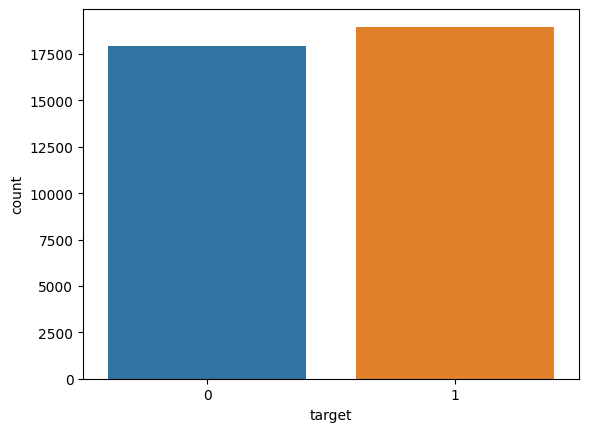

In [97]:
sns.countplot(x='target', data=df)
plt.show()

In [98]:
import pandas as pd
df = pd.DataFrame(df)

In [99]:
df = df.rename(columns={0: 'text' , 1:"target" , 2:"text_cleaned"})


In [100]:
df.head()

,text,target,text_cleaned
0,في المجمر يضرب الرصاص واللي فيه التوكال غير نش...,0,ما مجمر حشاكم غير يدرب تقيا خريا كلاموا توكال
1,لا دخان بدون نار كنت عارف ان الفيفا معطاتهمش م...,1,يخلسوا لا دخان مده بدون طويله معطاتهمش
2,ان هذه الحكومةالفت الابتزاز منذ ان جاات والان ...,0,ابتزاز تستنزف ما حكومهالفت جا بوجوه بق
3,لماذا عدد الوفيات جد مرتفع؟,0,وفي
4,الله ينعل بو الفلوس لي نطيح بيهم کرامتي,0,کرام نطيح ينعل


17500


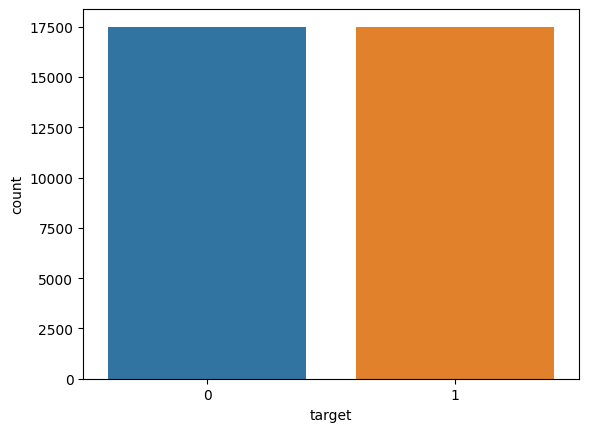

In [101]:
min_categry_value = 17500
print(min_categry_value)
major_class1 = df[df['target'] == 0].sample(n=min_categry_value , random_state=98)
major_class2 = df[df['target'] == 1].sample(n=min_categry_value , random_state=98)
df = pd.concat([major_class1, major_class2] )
df = df.sample(frac=1).reset_index(drop=True)
sns.countplot(df  , x='target' )
plt.show()

In [102]:
df.head()

,text,target,text_cleaned
0,دابا كون هي الي خانتووو وسمح ليها غتقولو عليه ...,0,غتقولو بامتياز منافق وسمح خانتو هه ودكور ديوث
1,أصبح كل من هب و دب يدلو بدلوه. الدين شامل يجمع...,1,عباده يدلو خطيب دب فقه تطرق وسايه بدلوه
2,قال رسول الله صلي الله عليه وسلم صوت المراه عو...,1,قوه لا بالخروج عديم والمبارزه عوره مراه وسلم
3,لابزاف صحافة ذيال زبل وهاد لوبية قال ليكم ماتع...,0,لمستو ماتعرفوش سحافه ديال لابزاف زبل لوبيه
4,صحافة الزبل اذهبي انت وسعد إلى الجحيم اما محسن...,0,فكر كويره وشهيد زبل جحيم ادهب ولقمه بشاحنه فرم...


In [103]:
df['target'].value_counts()

target
0    17500
1    17500
Name: count, dtype: int64

In [104]:
#df.drop(columns=['text'] , inplace=True)

In [105]:
df.to_csv("/kaggle/working/dataset.csv", index=False)